### Datos que contiene cada columna ###
https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mathplot
from sklearn.ensemble import IsolationForest

%matplotlib inline

# Extract data from Parquet file

In [3]:
url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet'
taxi_dataframe = pd.read_parquet(url, engine='pyarrow')
taxi_dataframe

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [4]:
taxi_dataframe.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

# Transform data

Choosing the columns we are interested in

In [5]:
taxi_dataframe = taxi_dataframe[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'total_amount']]

In [6]:
taxi_dataframe.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.72,1.0,186,79,2,22.70
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.80,1.0,140,236,1,18.75
2,2024-01-01 00:17:06,2024-01-01 00:35:01,4.70,1.0,236,79,1,31.30
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.40,1.0,79,211,1,17.00
4,2024-01-01 00:46:51,2024-01-01 00:52:57,0.80,1.0,211,148,1,16.10


#### Let see the data graphically

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'trip_distance'}>],
       [<Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>,
        <Axes: title={'center': 'DOLocationID'}>],
       [<Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'total_amount'}>, <Axes: >]], dtype=object)

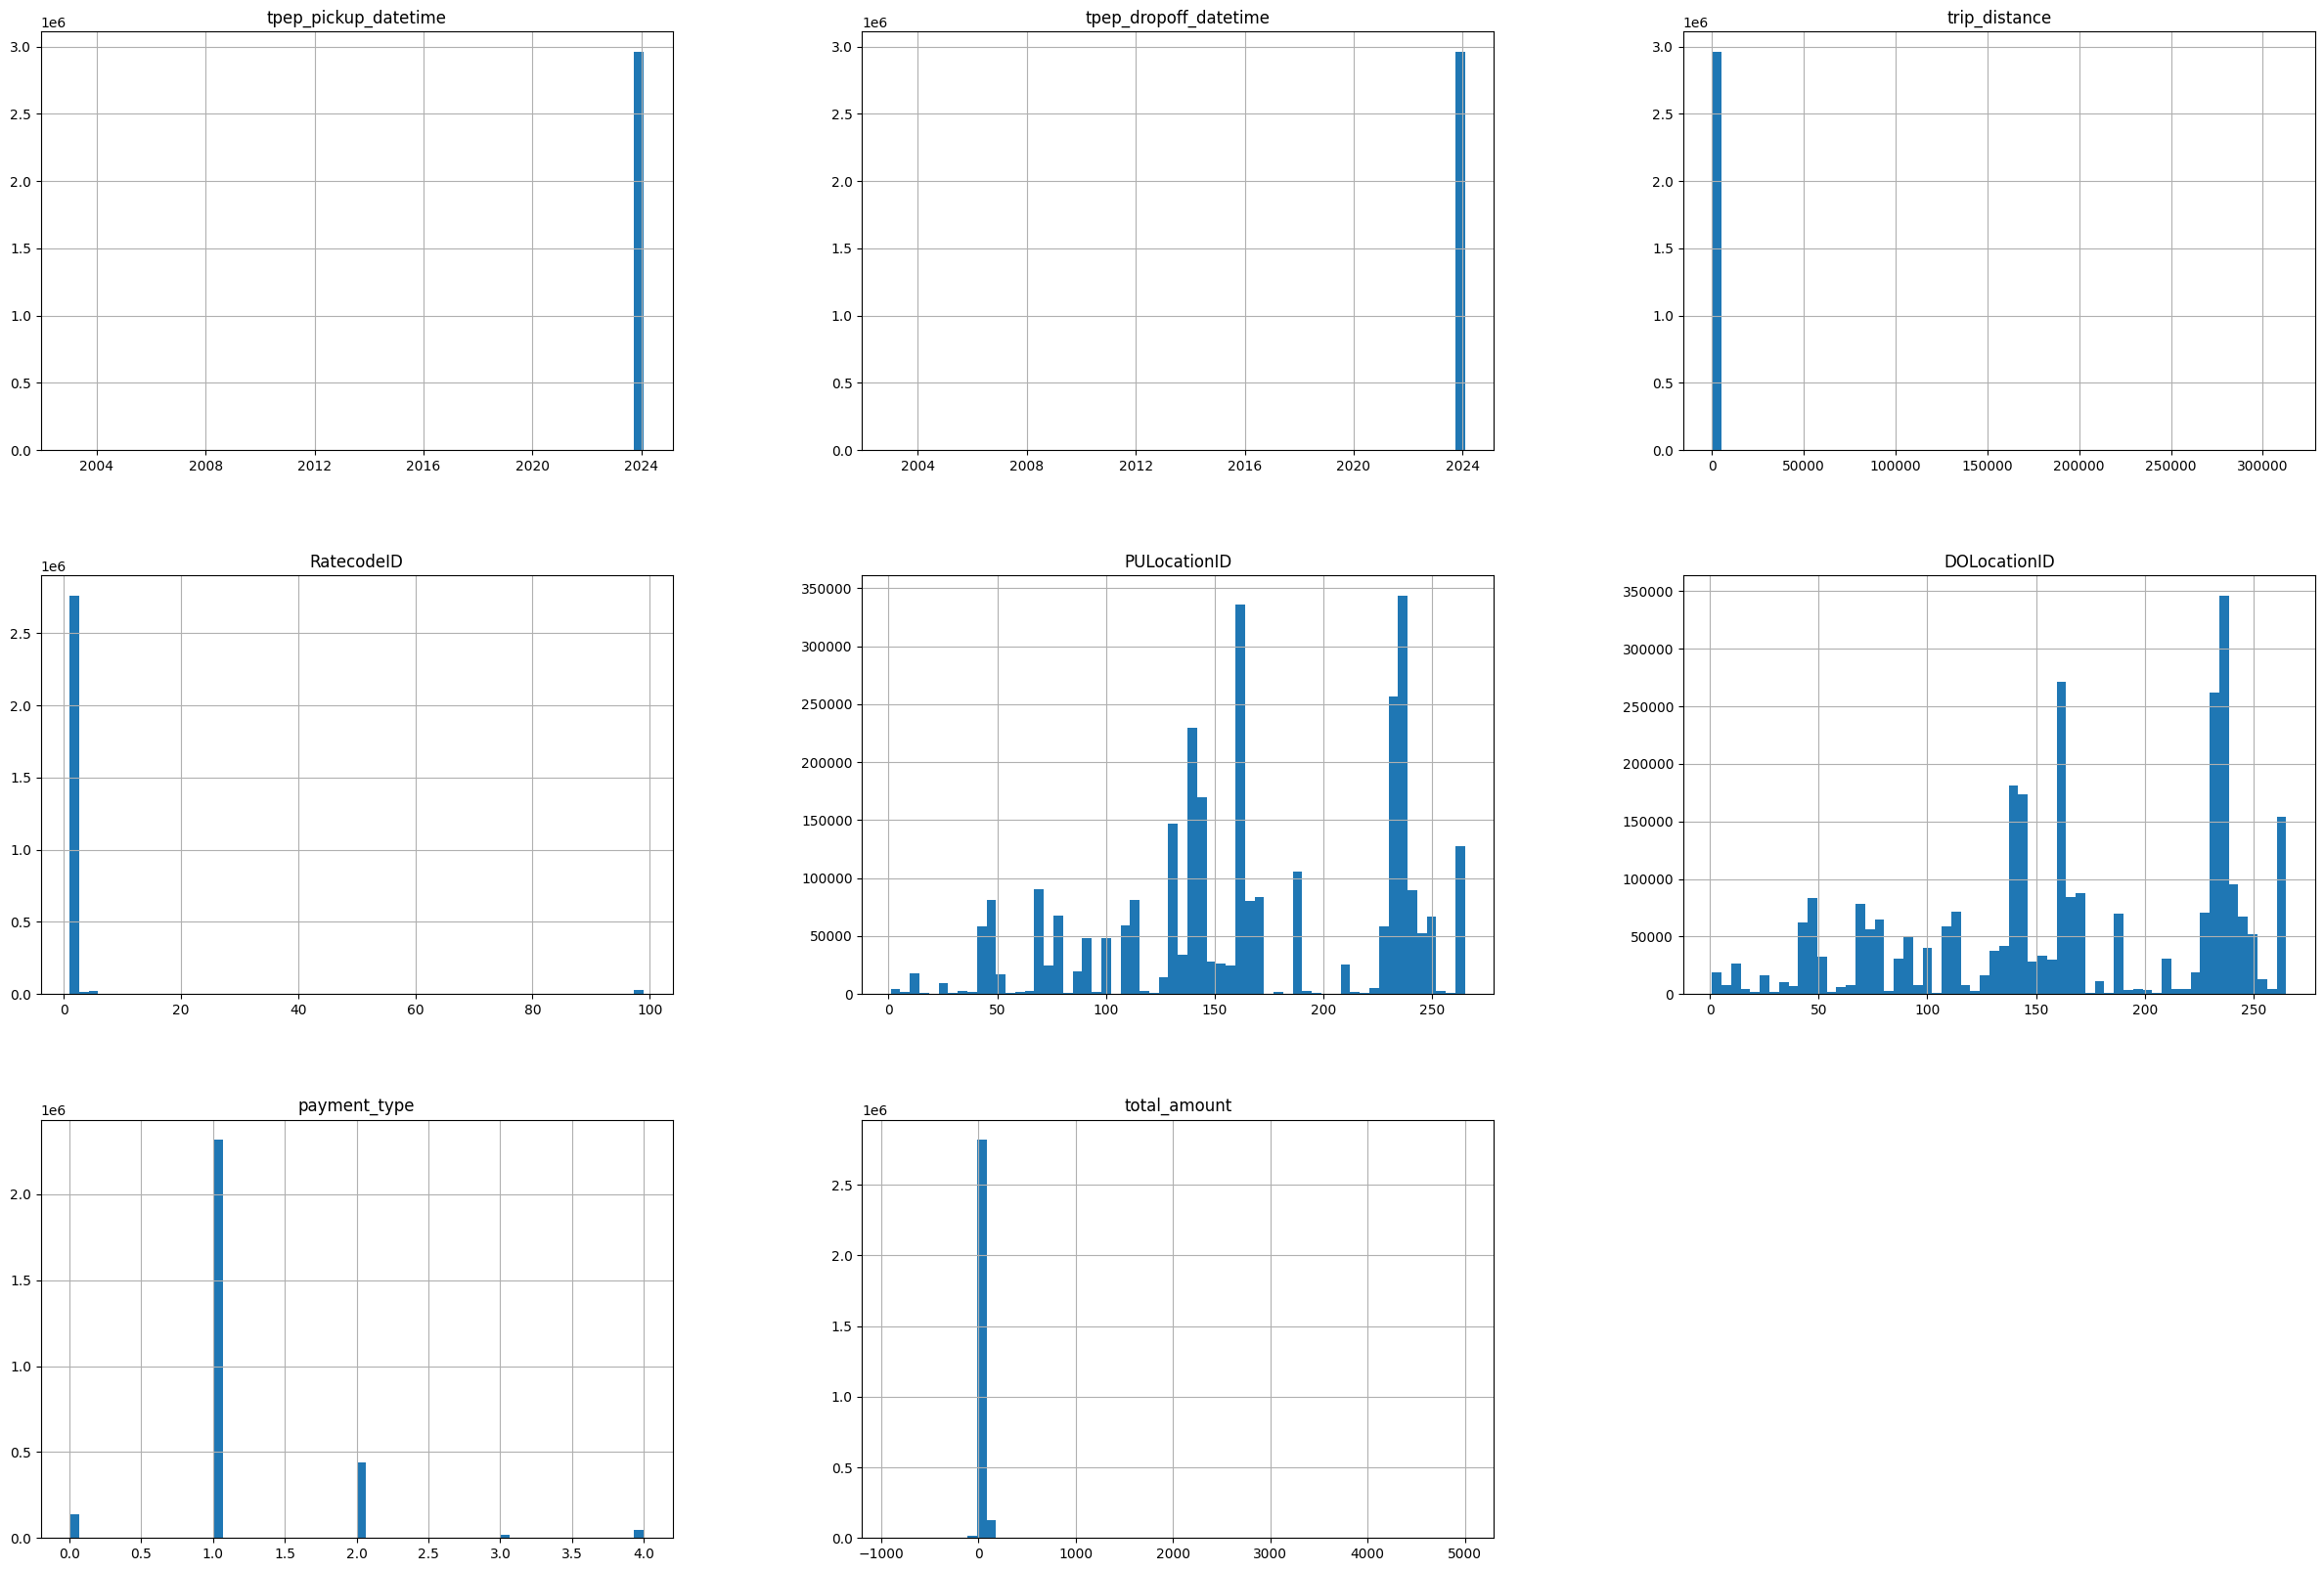

In [7]:
taxi_dataframe.hist(figsize=(30,20), bins=60)

There are columns that need some fixing:
- RatecodeID column, according to the pdf, only have six possible ID's. But we see different values.
- Negative values and huge amounts values in total_amount
- Years that are not 2024 and months different from january
- Huge trip distances or too low trip_distances convined with unproportional total_amount
- Doesn't appear graphically but there are NaN/null cells

In [8]:
taxi_dataframe['RatecodeID'].value_counts()

RatecodeID
1.0     2663350
2.0       98713
99.0      28663
5.0       19410
3.0        7954
4.0        6365
6.0           7
Name: count, dtype: int64

#### Wrong data in column RatecodeID

A 99 was marked 28663 times as rate code.
- Context: RatecodeID is a column that indicates the type of fare applied, with a defined set of valid values.
- Action: Records with RatecodeID values that did not belong to the expected set were identified and removed.
- Impact: Ensures that all records in the dataset have recognized fare codes, enabling accurate analysis of fares by type.

In [9]:
wrong_ratecode = taxi_dataframe[taxi_dataframe['RatecodeID'] > 6].shape[0]
total_data = taxi_dataframe.shape[0]

wrong_ratecode_percent = (wrong_ratecode / total_data) * 100
print(f'Número de campos erroneos en ratecode: {wrong_ratecode} \nPercentage of wronk RatecodeID over total of rows: {wrong_ratecode_percent:.3f}%')

Número de campos erroneos en ratecode: 28663 
Percentage of wronk RatecodeID over total of rows: 0.967%


#### Null or NaN data
- Context: The presence of null or NaN values in any key column could lead to incomplete or incorrect results in the analysis.
- Action: All records containing null or NaN values in essential columns were removed.
- Impact: This step ensures that all records in the dataset are complete and valid for analysis.

In [10]:
null_data = taxi_dataframe.isna().sum().sum()

null_percent = (null_data / total_data) * 100
print(f'NaN/null data: {null_data} \nPercentage of NaN/null data over total of rows: {null_percent:.3f}%')

NaN/null data: 140162 
Percentage of NaN/null data over total of rows: 4.728%


All Nan/null data seems to be located in RatecodeID column

In [11]:
wrong_ratecode_data = wrong_ratecode_percent + null_percent

print(f'Total incorrect data: {wrong_ratecode + null_data}')
print(f'Total over the column: {(((wrong_ratecode + null_data) / total_data) * 100):.3f}%')

f'Total of unwanted data in RatecodeId: {wrong_ratecode_data:.3f}%'

Total incorrect data: 168825
Total over the column: 5.695%


'Total of unwanted data in RatecodeId: 5.695%'

#### Negatives values in column total_amount.
- Context: Records with negative values were found in the total_amount column, which is inconsistent with the logic of the data (since a negative fare doesn’t make sense).
- Action: All records with negative values in total_amount were removed.
- Impact: This prevents distortion in future analyses, as these negative values do not reflect real fares.

In [12]:
negative_values = taxi_dataframe[taxi_dataframe['total_amount'] < 0].shape[0]
negative_values_percent = (negative_values / total_data) * 100

negative_values_column = (negative_values / total_data) * 100

print(f"Negative percentage in 'total_amount': {negative_values_column:.2f}%")

Negative percentage in 'total_amount': 1.20%


Cleaning wrong data and null data in RatecodeID, and drop negative values in total_amount

In [13]:
taxi_dataframe_filtered = taxi_dataframe[(taxi_dataframe['RatecodeID'] <= 6) & (taxi_dataframe['total_amount'] > 0)]

taxi_dataframe_filtered = taxi_dataframe_filtered.dropna()

print('''Data cleaning so far: ''')
print(taxi_dataframe_filtered['RatecodeID'].value_counts())
print('''\nDatos negativos en total_amount''')
print(taxi_dataframe_filtered[taxi_dataframe_filtered['total_amount'] < 0].shape[0])
print(f'\nCampos nulos: \n{taxi_dataframe_filtered.isnull().sum()}')

Data cleaning so far: 
RatecodeID
1.0    2630858
2.0      96658
5.0      18640
3.0       7617
4.0       6144
6.0          5
Name: count, dtype: int64

Datos negativos en total_amount
0

Campos nulos: 
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64


In [14]:
print(f'Datos originales: {taxi_dataframe.shape}')

print(f'Datos filtrados: {taxi_dataframe_filtered.shape}')

Datos originales: (2964624, 8)
Datos filtrados: (2759922, 8)


Changing the data types of RatecodeID, PULocationID, DOLocationID, payment_type columns.

In [15]:
for column in taxi_dataframe_filtered.columns:
    if 'ID' in column or 'payment_type' in column:
        taxi_dataframe_filtered.loc[:,column] = taxi_dataframe_filtered[column].astype('str')


C:\Users\dario.maroto\AppData\Local\Temp\ipykernel_18624\2506915822.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1.0' '1.0' '1.0' ... '1.0' '1.0' '1.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  taxi_dataframe_filtered.loc[:,column] = taxi_dataframe_filtered[column].astype('str')
C:\Users\dario.maroto\AppData\Local\Temp\ipykernel_18624\2506915822.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['186' '140' '236' ... '43' '142' '140']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  taxi_dataframe_filtered.loc[:,column] = taxi_dataframe_filtered[column].astype('str')
C:\Users\dario.maroto\AppData\Local\Temp\ipykernel_18624\2506915822.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pa

In [16]:
taxi_dataframe_filtered.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

In [17]:
taxi_dataframe_filtered

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.72,1.0,186,79,2,22.70
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.80,1.0,140,236,1,18.75
2,2024-01-01 00:17:06,2024-01-01 00:35:01,4.70,1.0,236,79,1,31.30
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.40,1.0,79,211,1,17.00
4,2024-01-01 00:46:51,2024-01-01 00:52:57,0.80,1.0,211,148,1,16.10
...,...,...,...,...,...,...,...,...
2824457,2024-01-31 23:10:28,2024-01-31 23:18:30,3.51,1.0,138,129,1,30.31
2824458,2024-01-31 23:01:04,2024-01-31 23:17:35,3.36,1.0,162,261,1,29.25
2824459,2024-01-31 23:08:13,2024-01-31 23:25:00,3.30,1.0,43,249,1,23.70
2824460,2024-01-31 23:49:46,2024-01-31 23:53:10,0.40,1.0,142,163,2,10.10


#### Let's see again the dataframe graphics

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

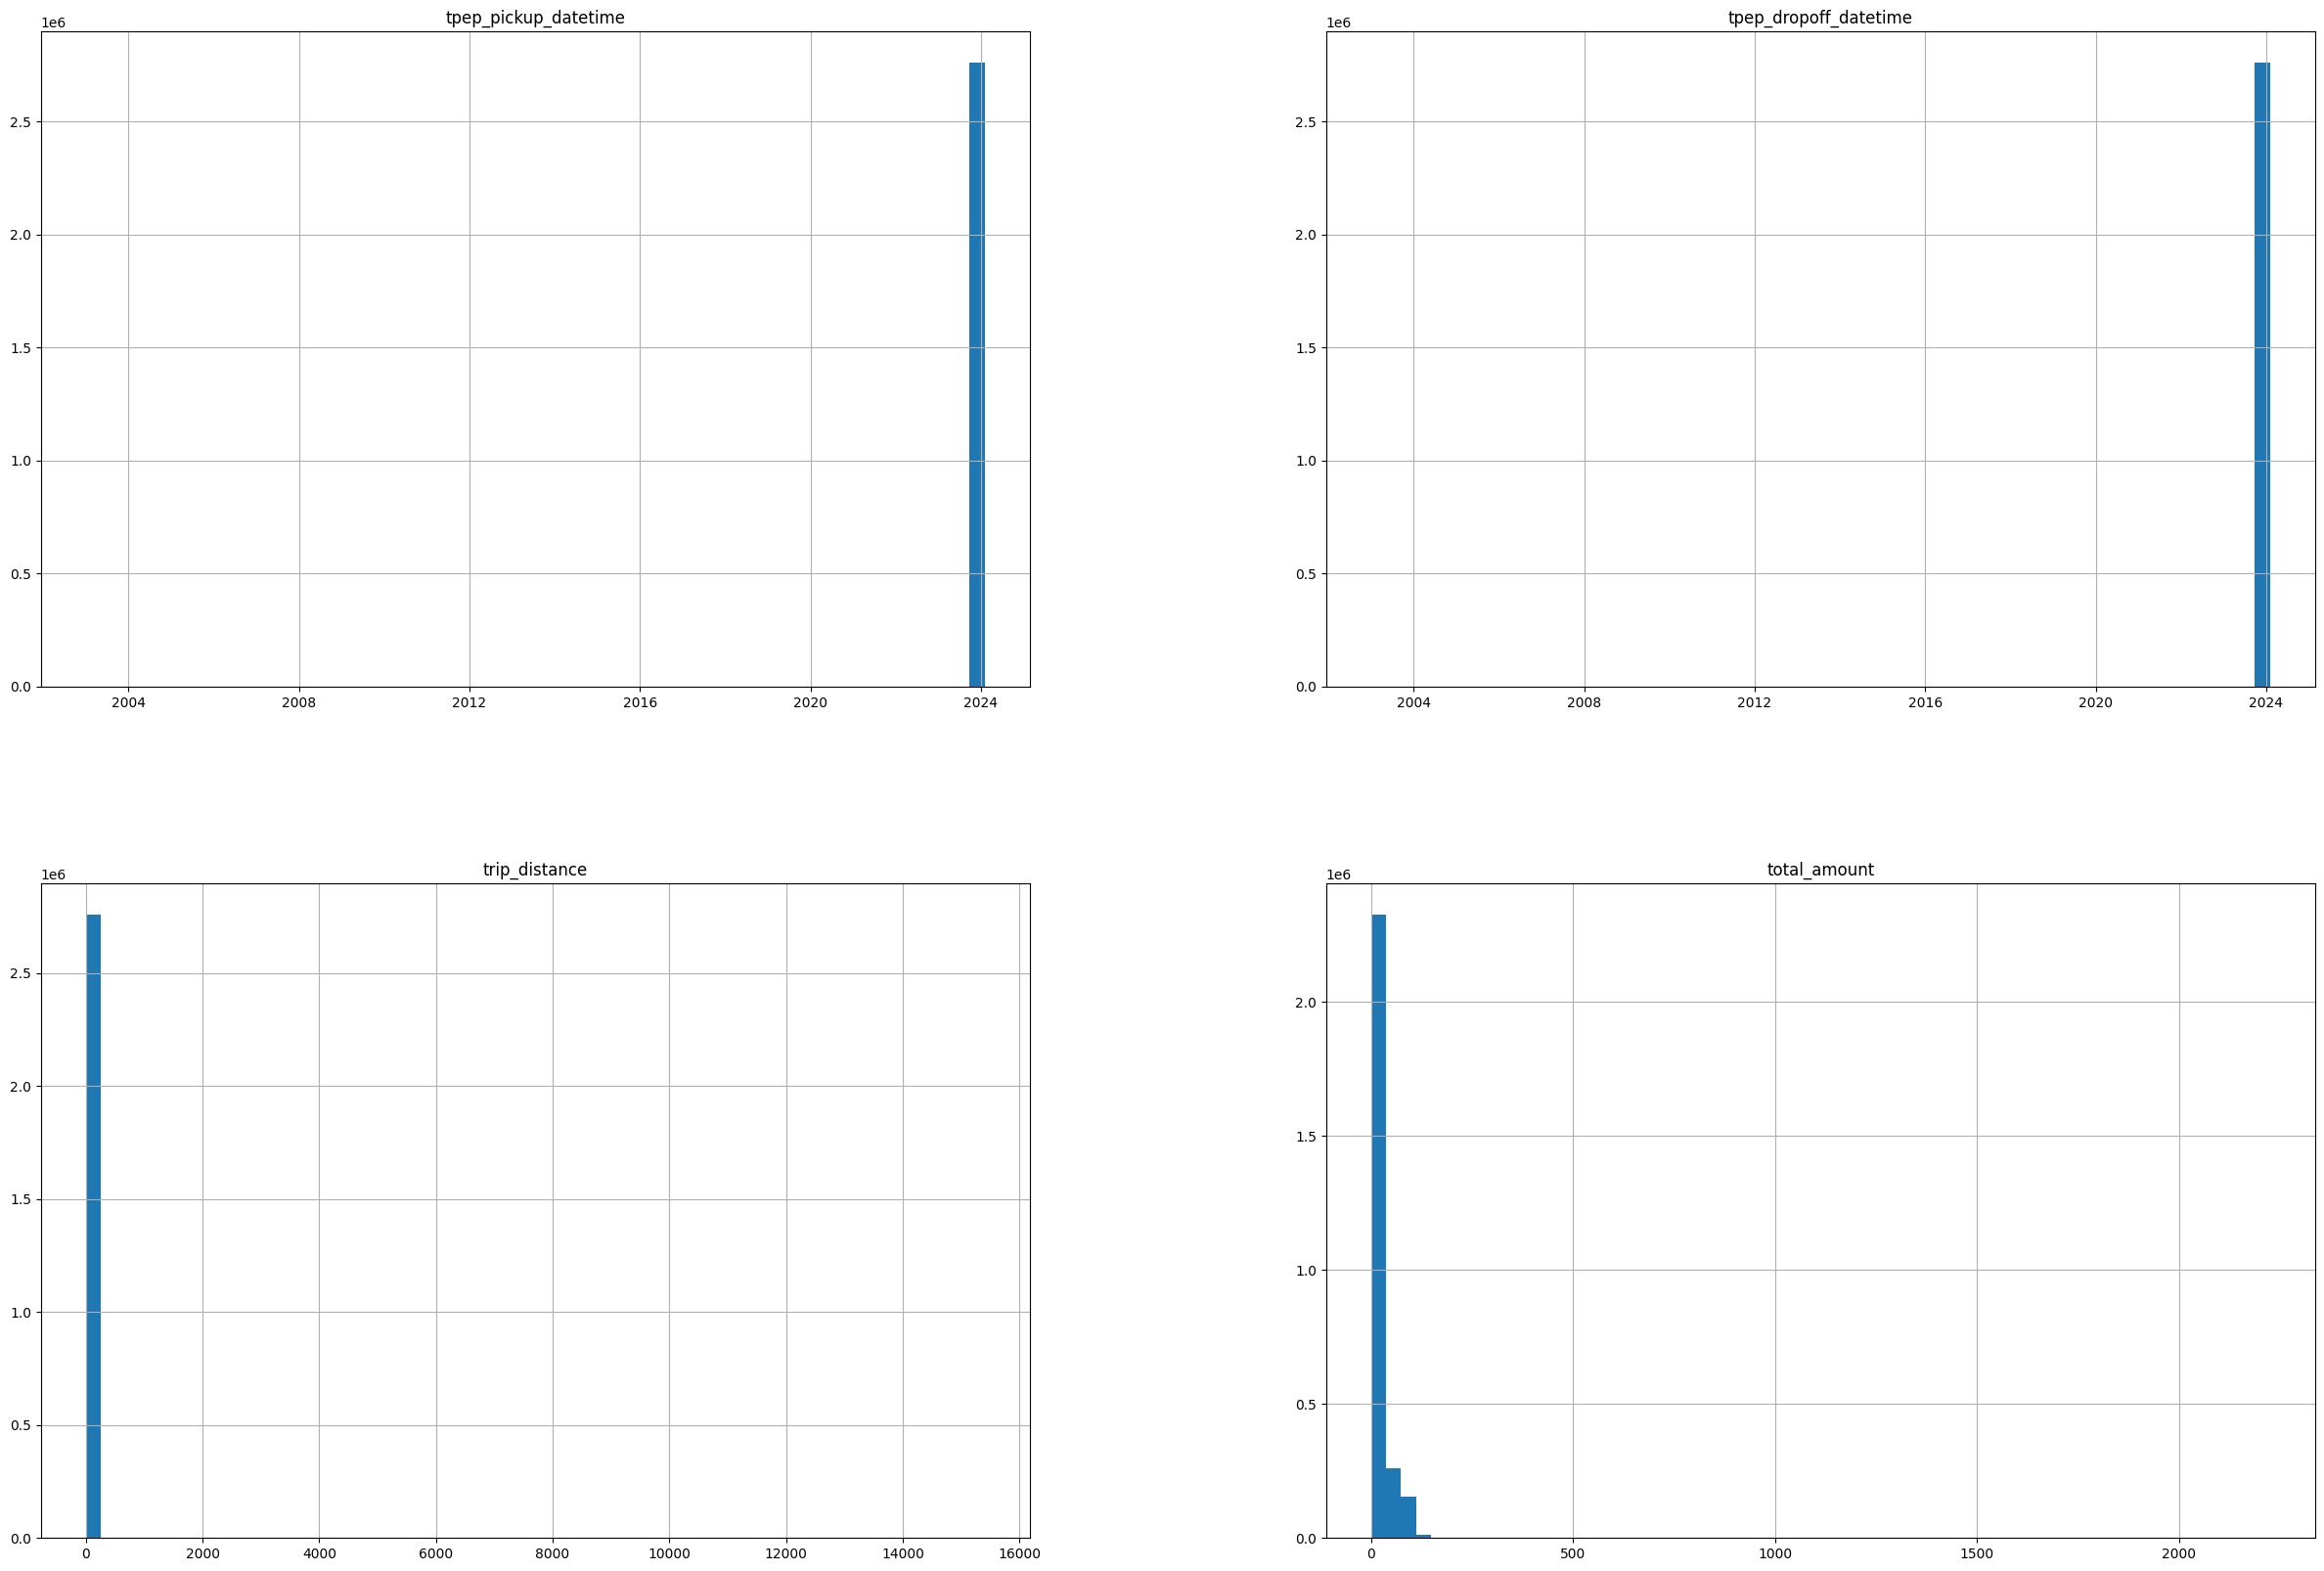

In [18]:
taxi_dataframe_filtered.hist(figsize=(30,20), bins=60)

### Linear relation between trip distance and total amount showing outliers

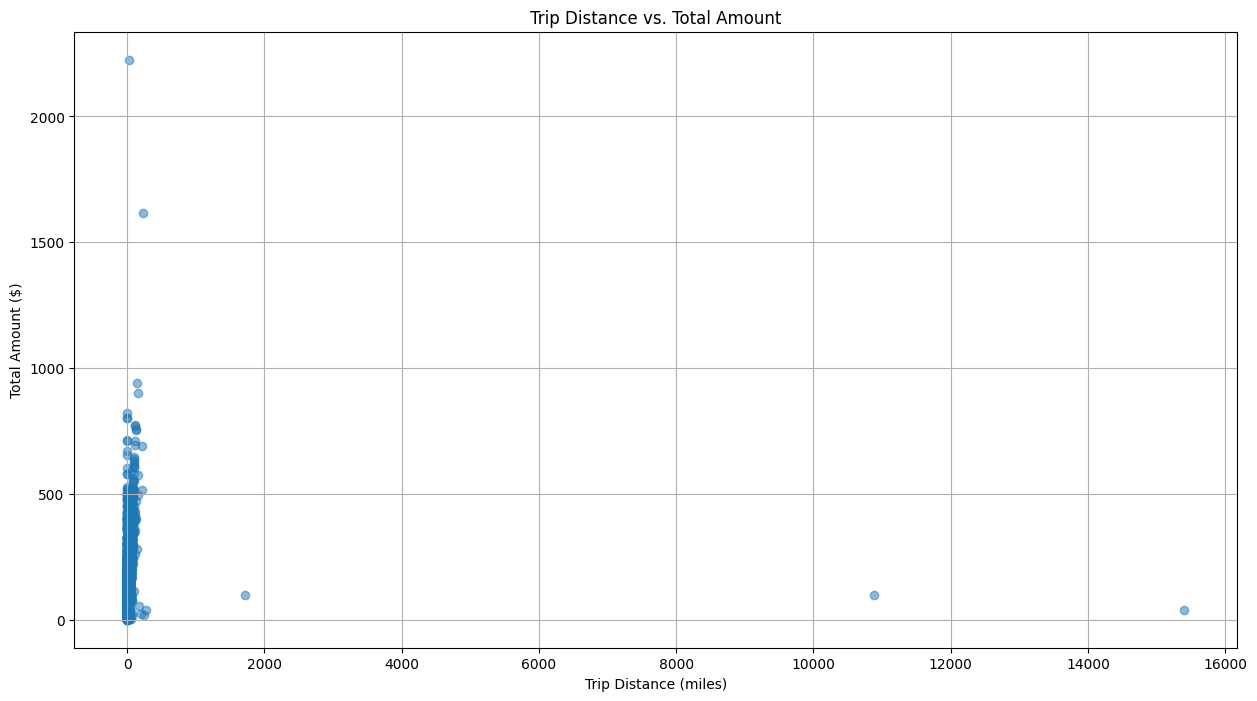

Descriptive Statistics:
        trip_distance  total_amount
count   2.759922e+06  2.759922e+06
mean    3.209680e+00  2.742040e+01
std     1.220827e+01  2.239270e+01
min     0.000000e+00  1.000000e-02
25%     1.000000e+00  1.540000e+01
50%     1.660000e+00  2.002000e+01
75%     3.040000e+00  2.850000e+01
max     1.540032e+04  2.225300e+03
Correlation between trip distance and total amount: 0.33


In [19]:
mathplot.figure(figsize=(15, 8))
mathplot.scatter(taxi_dataframe_filtered['trip_distance'], taxi_dataframe_filtered['total_amount'], alpha=0.5)
mathplot.title('Trip Distance vs. Total Amount')
mathplot.xlabel('Trip Distance (miles)')
mathplot.ylabel('Total Amount ($)')
mathplot.grid(True)
mathplot.show()

# 2. Cálculo de Estadísticas Descriptivas
stats = taxi_dataframe_filtered[['trip_distance', 'total_amount']].describe()
print("Descriptive Statistics:\n", stats)

# 3. Análisis de Correlación
correlation = taxi_dataframe_filtered[['trip_distance', 'total_amount']].corr().iloc[0, 1]
print(f"Correlation between trip distance and total amount: {correlation:.2f}")


### Dealing and cleaning with remaining problems in dataframe

- Context: The original dataset included data from different years and months.
- Action: The data was filtered to retain only records corresponding to January 2024.
- Impact: This step ensures that the analysis is specific to the period of interest, excluding data that is not relevant to the current investigation.

In [20]:
not_2024 = taxi_dataframe_filtered.loc[
  taxi_dataframe_filtered['tpep_pickup_datetime'].dt.year < 2024, ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
  ]

not_january = taxi_dataframe_filtered.loc[
  taxi_dataframe_filtered['tpep_pickup_datetime'].dt.month > 1, 
  ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
  ]

print(f"Años diferentes a 2024: \n {not_2024} \n")

print(f"Meses distintos de enero: \n{not_january} \n")

Años diferentes a 2024: 
         tpep_pickup_datetime tpep_dropoff_datetime
256      2023-12-31 23:56:46   2024-01-01 00:12:06
369      2023-12-31 23:39:17   2023-12-31 23:42:00
753      2023-12-31 23:41:02   2023-12-31 23:48:03
2210     2023-12-31 23:57:17   2024-01-01 00:01:50
2615     2023-12-31 23:56:45   2024-01-01 00:00:28
2985     2023-12-31 23:49:12   2024-01-01 00:04:32
3176     2023-12-31 23:47:28   2023-12-31 23:57:07
4137     2023-12-31 23:58:35   2024-01-01 00:13:06
4142     2023-12-31 23:58:37   2024-01-01 00:08:37
8628     2023-12-31 23:54:27   2024-01-01 00:13:12
10915    2009-01-01 23:58:40   2009-01-02 00:01:40
53120    2002-12-31 22:59:39   2002-12-31 23:05:41
1230169  2009-01-01 23:30:39   2009-01-02 00:01:39
2558056  2009-01-01 00:24:09   2009-01-01 01:13:00 

Meses distintos de enero: 
        tpep_pickup_datetime tpep_dropoff_datetime
256      2023-12-31 23:56:46   2024-01-01 00:12:06
369      2023-12-31 23:39:17   2023-12-31 23:42:00
753      2023-12-31 23:41:0

The new variable "taxi_data_prep" contains only data of January 2024

In [21]:
taxi_data_prep = taxi_dataframe_filtered.drop(
  taxi_dataframe_filtered[
  (taxi_dataframe_filtered['tpep_pickup_datetime'].dt.year != 2024)
  ].index)

taxi_data_prep = taxi_data_prep.drop(
  taxi_data_prep[
    (taxi_data_prep['tpep_pickup_datetime'].dt.month > 1) |
    (taxi_dataframe_filtered['tpep_dropoff_datetime'].dt.month > 1)
    ].index)

print('---- Months different to January ----')
print(taxi_data_prep.loc[
  ((taxi_data_prep['tpep_pickup_datetime'].dt.month > 1) &
    (taxi_dataframe_filtered['tpep_dropoff_datetime'].dt.month > 1)),
  ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
  ])

print('---- Years different to 2024 ---- ')
print(taxi_data_prep.loc[
  (taxi_data_prep['tpep_pickup_datetime'].dt.year != 2024), 
  # &(taxi_dataframe_filtered['tpep_pickup_datetime'].dt.month > 1),
  ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
  ])

C:\Users\dario.maroto\AppData\Local\Temp\ipykernel_18624\3736536068.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  taxi_data_prep[


---- Months different to January ----
Empty DataFrame
Columns: [tpep_pickup_datetime, tpep_dropoff_datetime]
Index: []
---- Years different to 2024 ---- 
Empty DataFrame
Columns: [tpep_pickup_datetime, tpep_dropoff_datetime]
Index: []


## Manual removal of Outliers in Trip Distance and Total Amount.
- Context: Outliers were defined as records where the total fare (total_amount) and trip distance (trip_distance) were excessively high or excessivley low relative to each other.
- Action: To clean the dataset, these outliers were removed by applying the Interquartile Range (IQR) method. Specifically, for each distance range, the first quartile (Q1) and third quartile (Q3) of the total fare were calculated, and any records with fares falling outside the range of [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] were considered outliers and removed. This method ensured that only fares within a reasonable range relative to their corresponding trip distances were retained.
- Impact:  The removal of outliers led to a reduction of 13.55% in the dataset size. This indicates that a modest but significant portion of the data consisted of atypical or potentially erroneous records. Cleaning the data in this way helps improve the reliability and accuracy of subsequent analyses, as it reduces the influence of extreme values that could skew the results.

In [29]:
def calculate_thresholds(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    return lower_bound, upper_bound

# Calculate thresholds for total_amount and trip_distance
lower_amount, upper_amount = calculate_thresholds(taxi_data_prep, 'total_amount')
lower_distance, upper_distance = calculate_thresholds(taxi_data_prep, 'trip_distance')

# Display the thresholds
print(f"Thresholds for total_amount: Lower = {lower_amount:.2f}, \nUpper = {upper_amount:.2f}")
print(f"Thresholds for trip_distance: Lower = {lower_distance:.2f}, \nUpper = {upper_distance:.2f}")

# Filter the data to remove outliers
taxi_df_cleaned = taxi_data_prep[
    (taxi_data_prep['total_amount'] >= lower_amount) & (taxi_data_prep['total_amount'] <= upper_amount) &
    (taxi_data_prep['trip_distance'] >= lower_distance) & (taxi_data_prep['trip_distance'] <= upper_distance)
]

with_outliers = taxi_data_prep.shape[0]
without_outliers = taxi_df_cleaned.shape[0]

# Display the shape of the original and cleaned data
print(f"Original datasetset shape: {with_outliers}")
print(f"Cleaned dataset shape: {without_outliers}")
print(f"Percent of outliers: {((with_outliers - without_outliers )/ with_outliers) * 100:.2f}%")

Thresholds for total_amount: Lower = -4.23, 
Upper = 48.12
Thresholds for trip_distance: Lower = -2.06, 
Upper = 6.10
Original datasetset shape: 2759316
Cleaned dataset shape: 2385428
Percent of outliers: 13.55


### Linear relation between trip distance and total amount after cleaning outliers
Showing how correlation is stronger now.

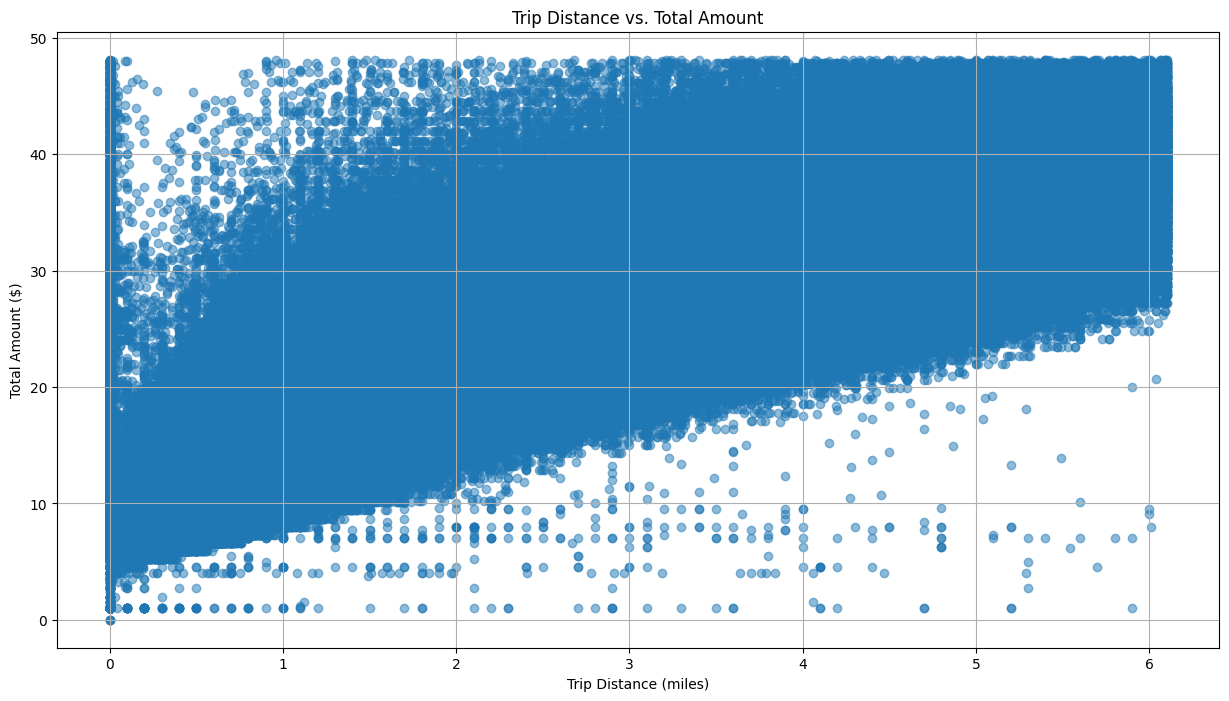

Descriptive Statistics:
        trip_distance  total_amount
count   2.385428e+06  2.385428e+06
mean    1.773781e+00  2.007349e+01
std     1.178482e+00  7.166716e+00
min     0.000000e+00  1.000000e-02
25%     9.200000e-01  1.480000e+01
50%     1.470000e+00  1.850000e+01
75%     2.300000e+00  2.400000e+01
max     6.100000e+00  4.812000e+01
Correlation between trip distance and total amount: 0.86


In [23]:
mathplot.figure(figsize=(15, 8))
mathplot.scatter(taxi_df_cleaned['trip_distance'], taxi_df_cleaned['total_amount'], alpha=0.5)
mathplot.title('Trip Distance vs. Total Amount')
mathplot.xlabel('Trip Distance (miles)')
mathplot.ylabel('Total Amount ($)')
mathplot.grid(True)
mathplot.show()


# 2. Cálculo de Estadísticas Descriptivas
stats = taxi_df_cleaned[['trip_distance', 'total_amount']].describe()
print("Descriptive Statistics:\n", stats)

# 3. Análisis de Correlación
correlation = taxi_df_cleaned[['trip_distance', 'total_amount']].corr().iloc[0, 1]
print(f"Correlation between trip distance and total amount: {correlation:.2f}")


## Using model IsolationForest from scikit-learn to remove outliers from trip distance and total amount
Showing how the linear relationship and correlation have improved compared to manual cleaning, with significantly less data loss.<br />
<sup><sub>May take more than 45 seconds to complete</sub></sup>

In [34]:
features = taxi_data_prep[['trip_distance', 'total_amount']]

# Inicializar el modelo Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # contamination is the proportion of outliers

# Entrenar el modelo
outliers = iso_forest.fit_predict(features)

# outliers será 1 para inliers y -1 para outliers, entonces los filtramos
taxi_no_outliers = taxi_data_prep[outliers == 1]

with_outliers = taxi_data_prep.shape[0]
without_outliers = taxi_no_outliers.shape[0]
# Comparar tamaños antes y después de la limpieza
print(f"Original dataset shape: {with_outliers}")
print(f"Dataset shape after removing outliers: {without_outliers}")
print(f"Percent of outliers: {((with_outliers - without_outliers )/ with_outliers) * 100:.2f}%")

Original dataset shape: 2759316
Dataset shape after removing outliers: 2731722
Percent of outliers: 1.00%


#### Linear correlation figure

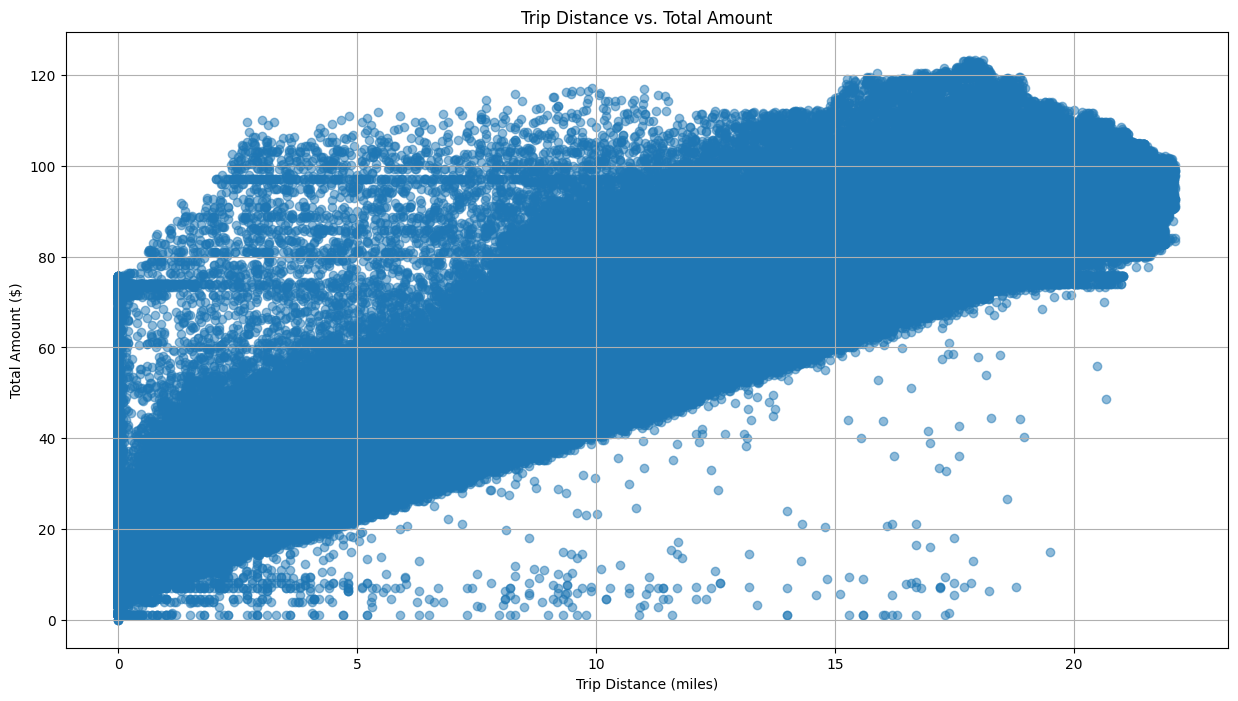

Descriptive Statistics:
        trip_distance  total_amount
count   2.731722e+06  2.731722e+06
mean    3.061446e+00  2.641171e+01
std     3.938927e+00  1.932933e+01
min     0.000000e+00  1.000000e-02
25%     1.000000e+00  1.540000e+01
50%     1.650000e+00  1.982000e+01
75%     3.000000e+00  2.800000e+01
max     2.213000e+01  1.233800e+02
Correlation between trip distance and total amount: 0.95


In [35]:
mathplot.figure(figsize=(15, 8))
mathplot.scatter(taxi_no_outliers['trip_distance'], taxi_no_outliers['total_amount'], alpha=0.5)
mathplot.title('Trip Distance vs. Total Amount')
mathplot.xlabel('Trip Distance (miles)')
mathplot.ylabel('Total Amount ($)')
mathplot.grid(True)
mathplot.show()

# 2. Descriptive statistics
stats = taxi_no_outliers[['trip_distance', 'total_amount']].describe()
print("Descriptive Statistics:\n", stats)

# 3. Correlation
correlation = taxi_no_outliers[['trip_distance', 'total_amount']].corr().iloc[0, 1]
print(f"Correlation between trip distance and total amount: {correlation:.2f}")

### Daily average and month average spent in January

In [37]:
daily_mean = taxi_df_cleaned.groupby(taxi_df_cleaned['tpep_pickup_datetime'].dt.day)['total_amount'].mean()
print("Daily average spent in January:")
for day, avg in daily_mean.items():
    print(f"Day {day}: ${avg:.2f}")

# Calcular el gasto promedio diario
average_month_spent = daily_mean.mean()
print(f"Complete month average spent in January is: {average_month_spent:.2f}")

Daily average spent in January:
Day 1: $20.10
Day 2: $19.74
Day 3: $19.84
Day 4: $20.72
Day 5: $20.32
Day 6: $19.19
Day 7: $18.43
Day 8: $19.74
Day 9: $19.88
Day 10: $20.24
Day 11: $20.70
Day 12: $20.33
Day 13: $19.79
Day 14: $19.28
Day 15: $18.59
Day 16: $20.45
Day 17: $20.53
Day 18: $20.65
Day 19: $19.98
Day 20: $19.36
Day 21: $18.72
Day 22: $19.90
Day 23: $20.81
Day 24: $20.89
Day 25: $21.04
Day 26: $20.49
Day 27: $20.35
Day 28: $19.01
Day 29: $19.87
Day 30: $20.53
Day 31: $20.77
Complete month average spent in January is: 20.01


### Number of trips per day

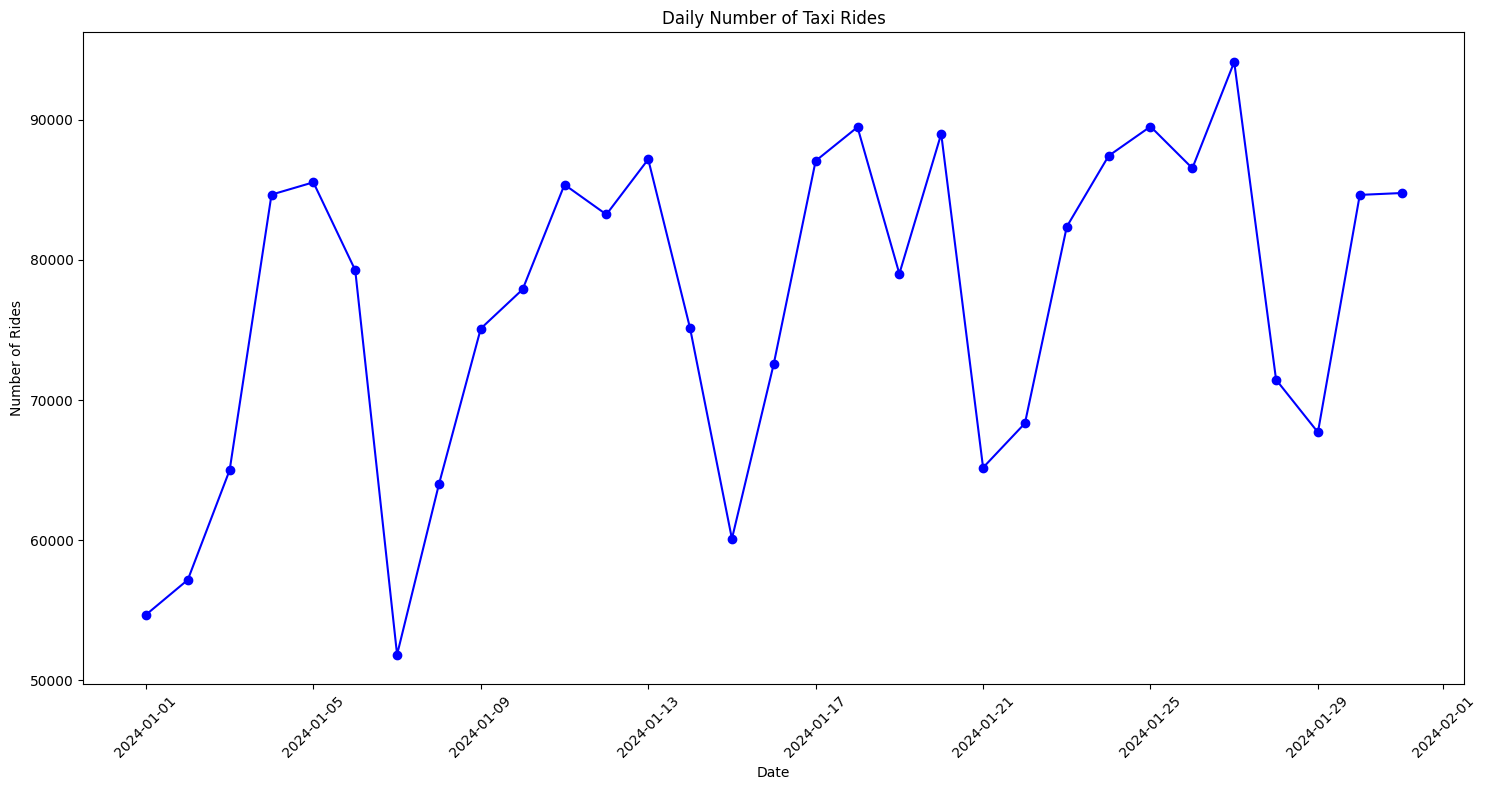

In [38]:
# Agrupar por día y contar el número de viajes
daily_rides = taxi_df_cleaned.groupby(taxi_df_cleaned['tpep_pickup_datetime'].dt.date).size()

# Visualizar el número de viajes por día
daily_rides.plot(title='Daily Number of Taxi Rides', xlabel='Date', ylabel='Number of Rides', figsize=(15, 8), marker='o', linestyle='-', color='b')
mathplot.xticks(rotation=45)  # Rote las etiquetas de fecha para que se muestren claramente
mathplot.tight_layout()
mathplot.show()

# TODO: El pickup location se puede dejar como númerico y con mode se puede ver qué zona se repite más

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

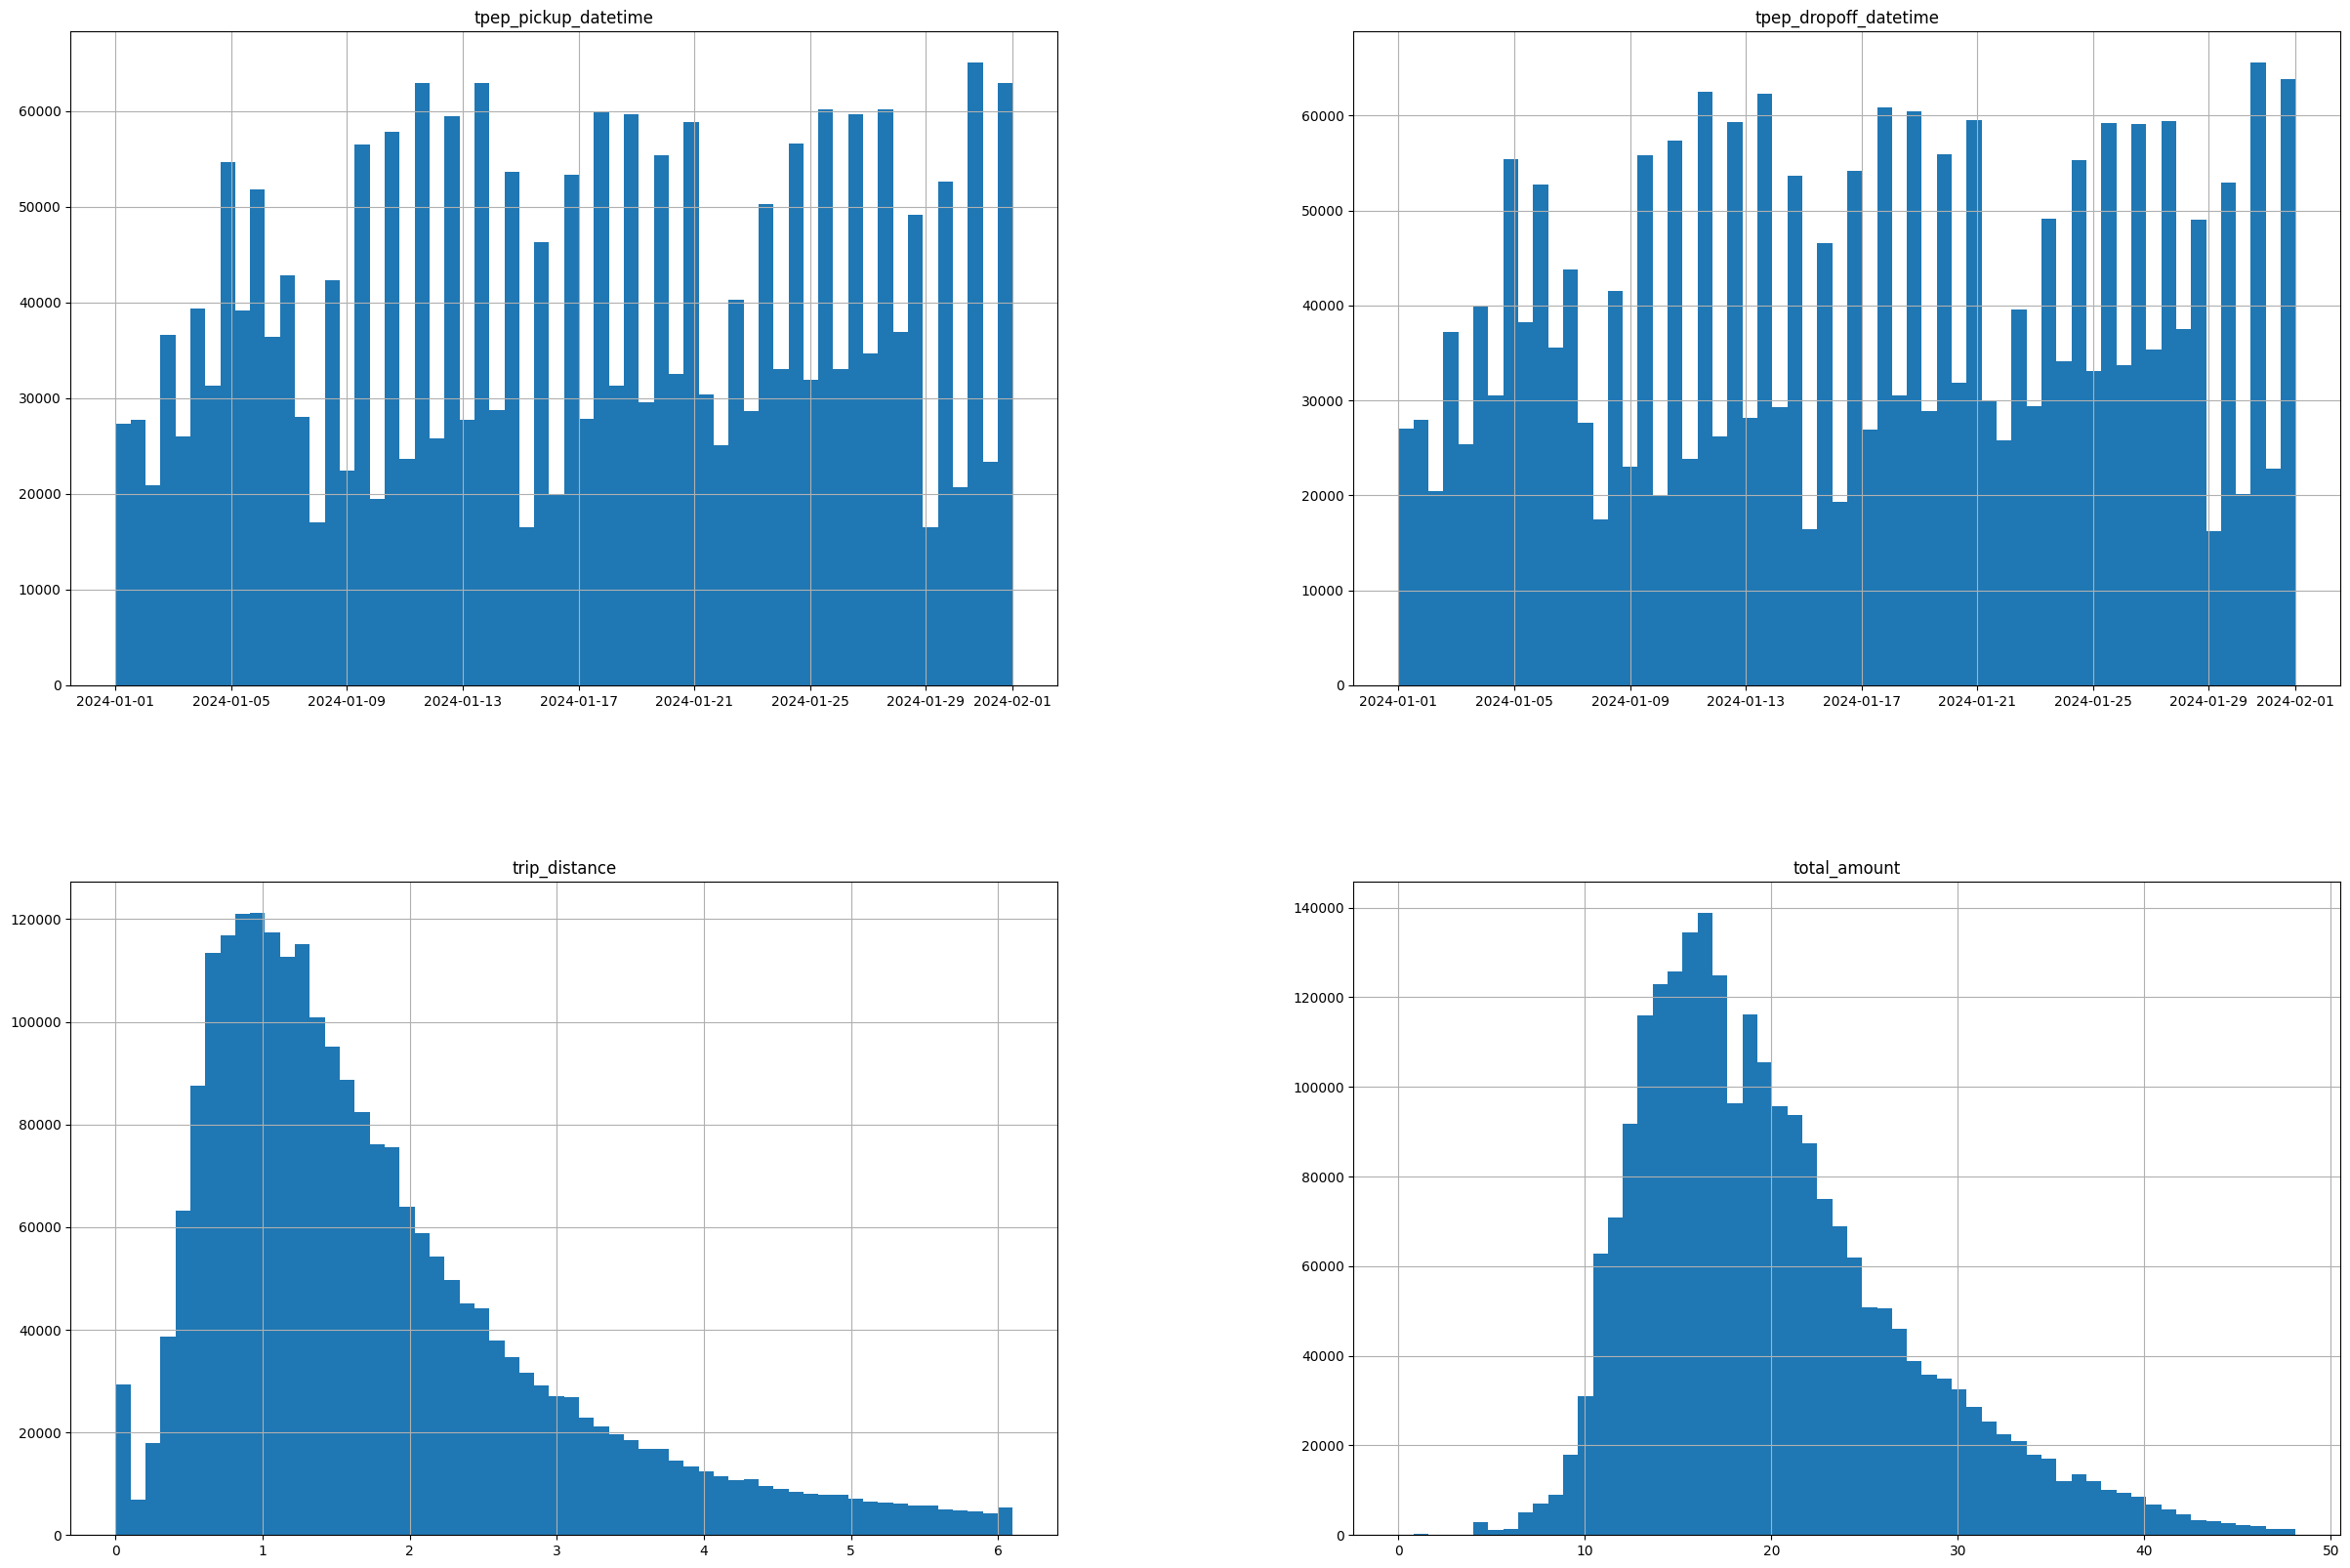

In [27]:
taxi_df_cleaned.hist(figsize=(30,20), bins=60)

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

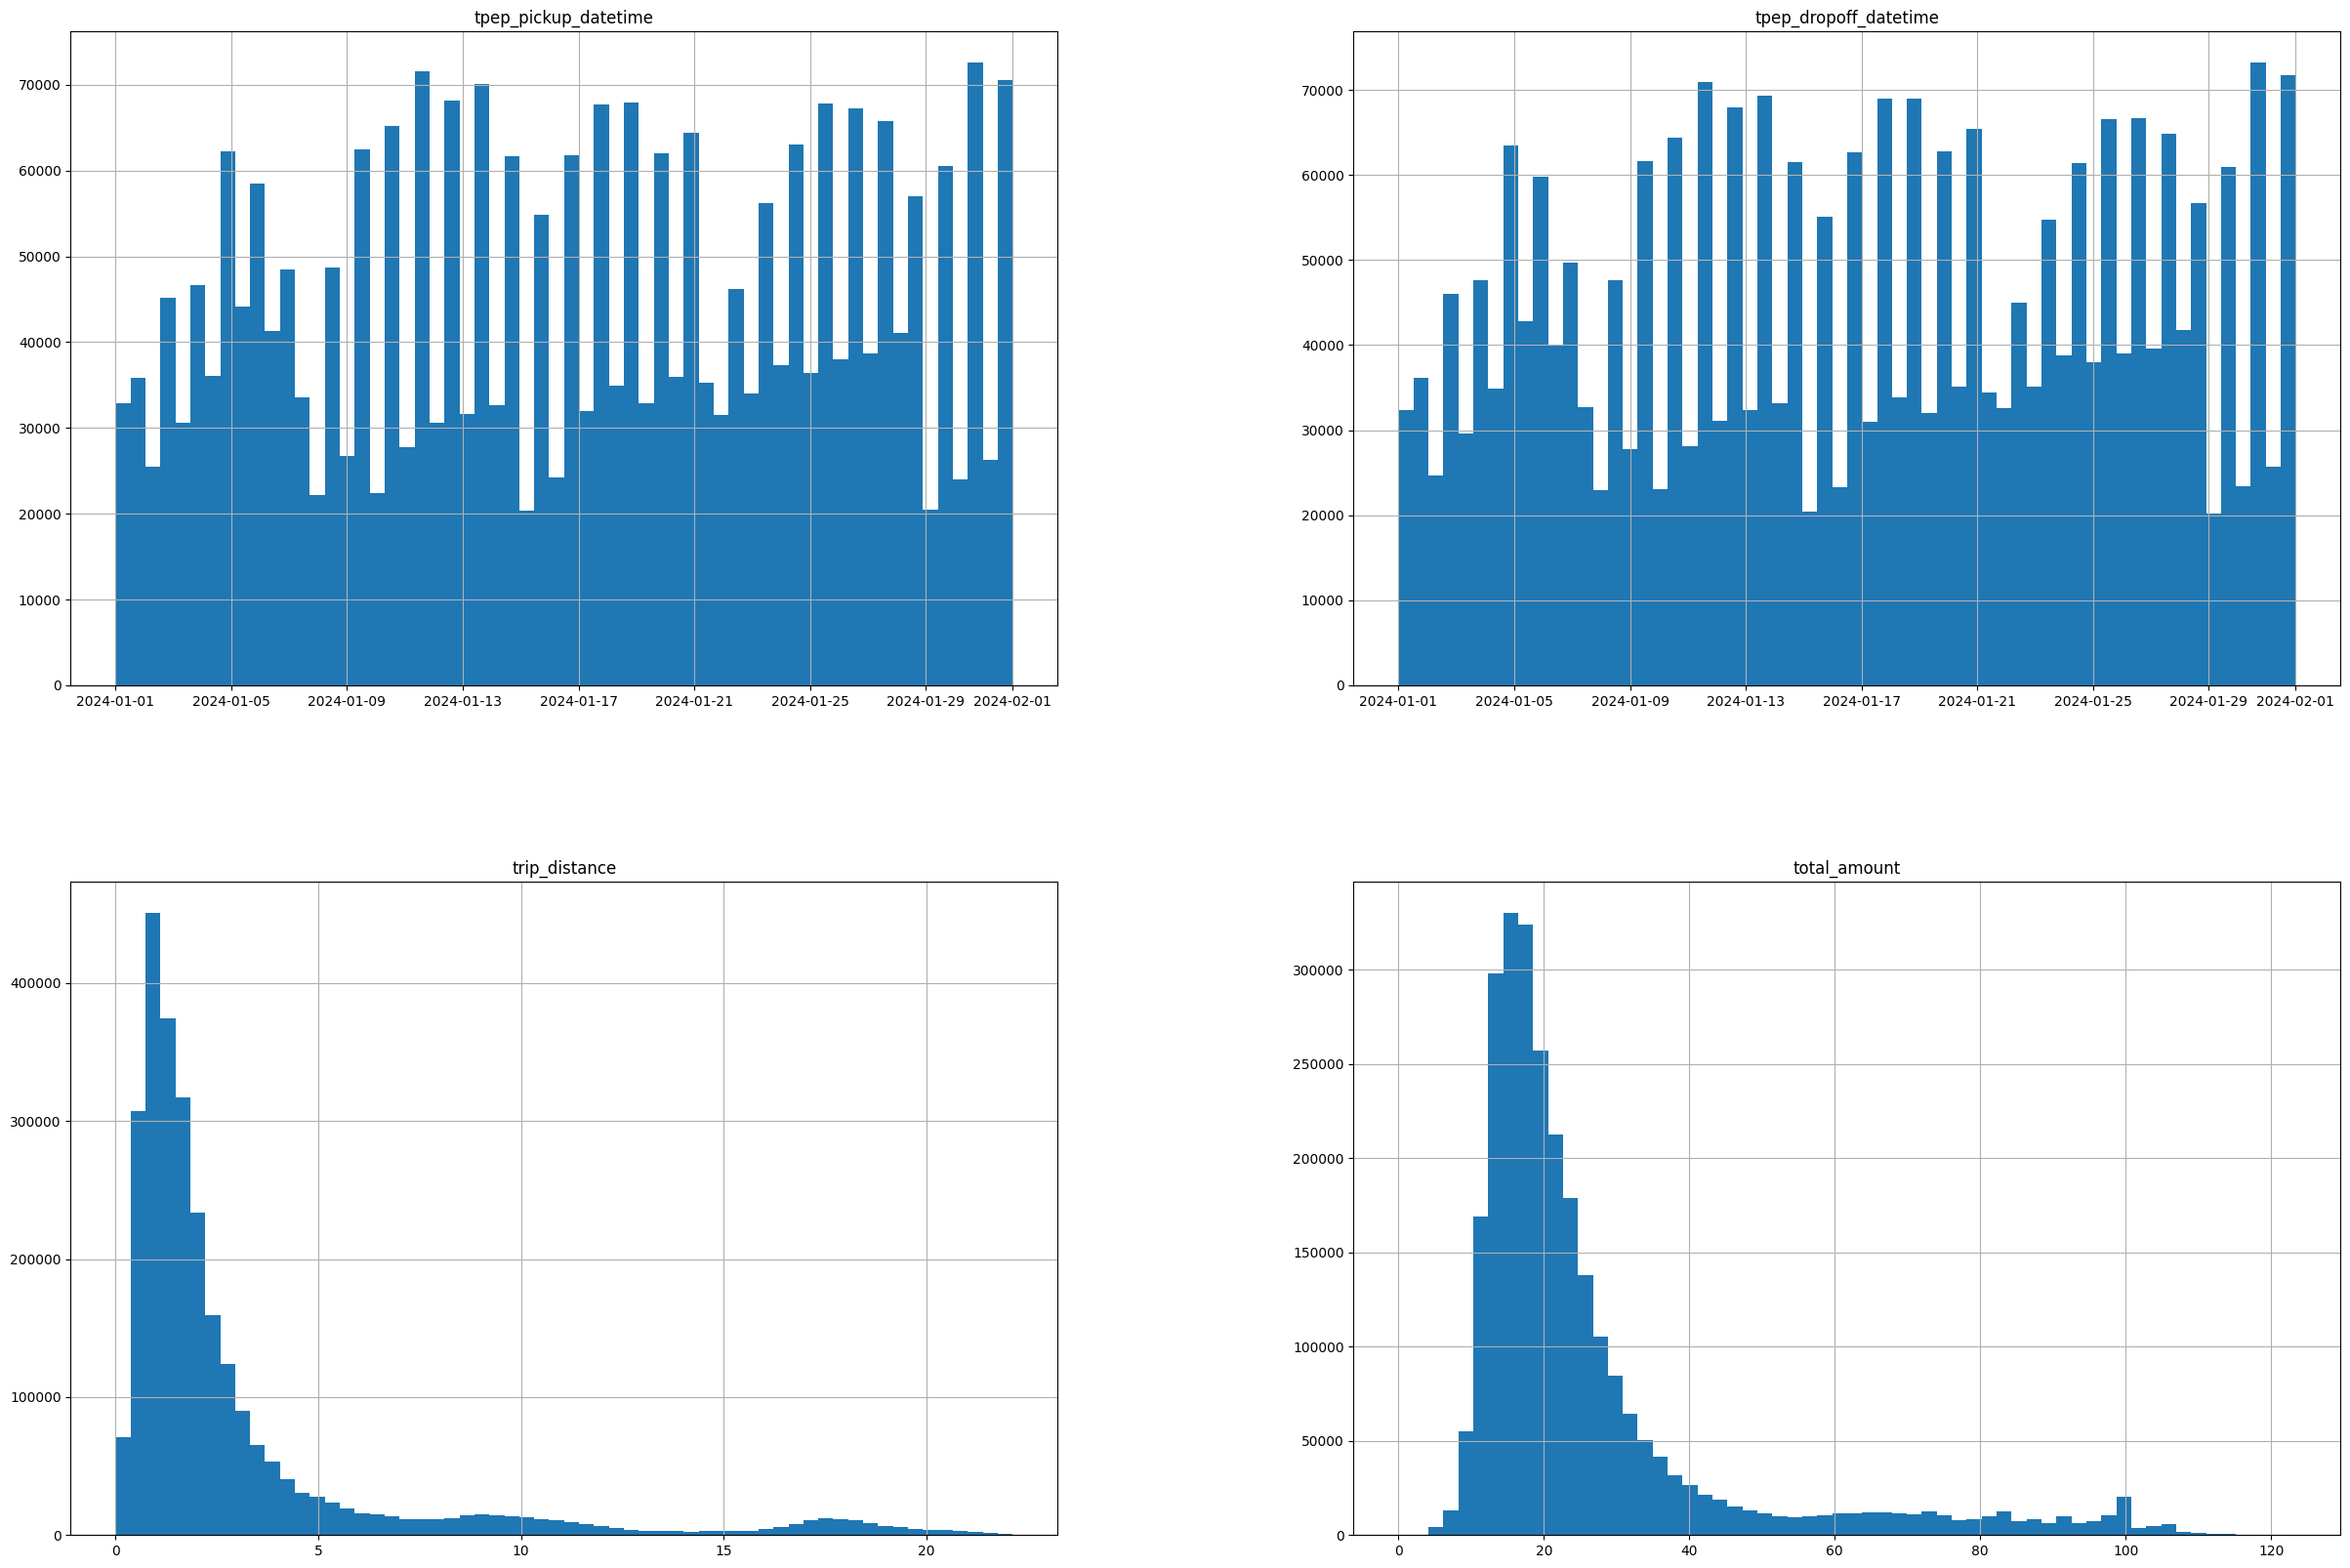

In [36]:
taxi_no_outliers.hist(figsize=(30,20), bins=60)

In [44]:
pulocation_counts = taxi_df_cleaned['PULocationID'].value_counts()
print(f'Top 5 pick-up location: {pulocation_counts.head(5)}')
print(f'Top 10 pick-up location: {pulocation_counts.head(10)}')

pulocation_counts2 = taxi_no_outliers['PULocationID'].value_counts()
# print(pulocation_counts2)

print(f"The most common Pick Up Location is {pulocation_counts.idxmax()} with {pulocation_counts.max()} pick-ups.")

Top 5 pick-up location: PULocationID
237    133541
161    127988
236    125522
162     96338
186     95788
Name: count, dtype: int64
Top 10 pick-up location: PULocationID
237    133541
161    127988
236    125522
162     96338
186     95788
142     95626
230     89270
239     79854
163     76719
170     74291
Name: count, dtype: int64
The most common Pick Up Location is 237 with 133541 pick-ups.


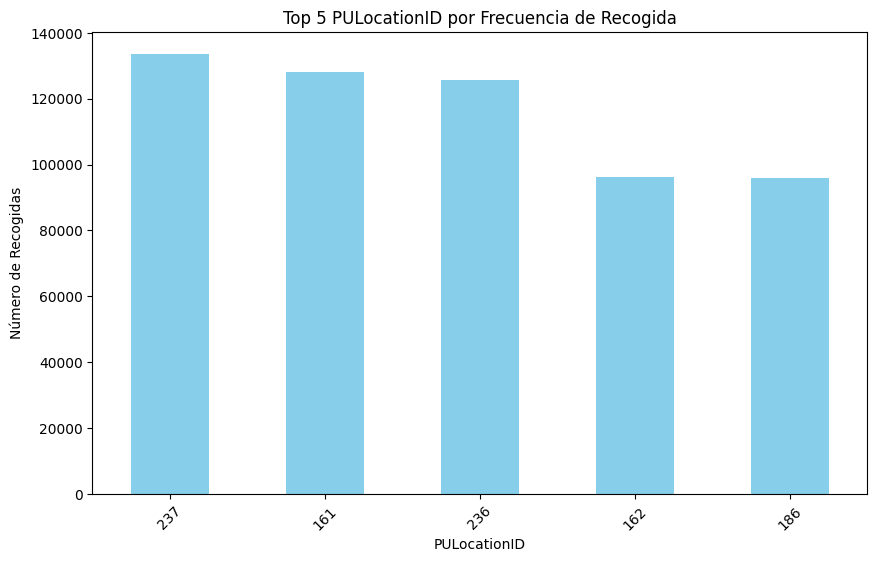

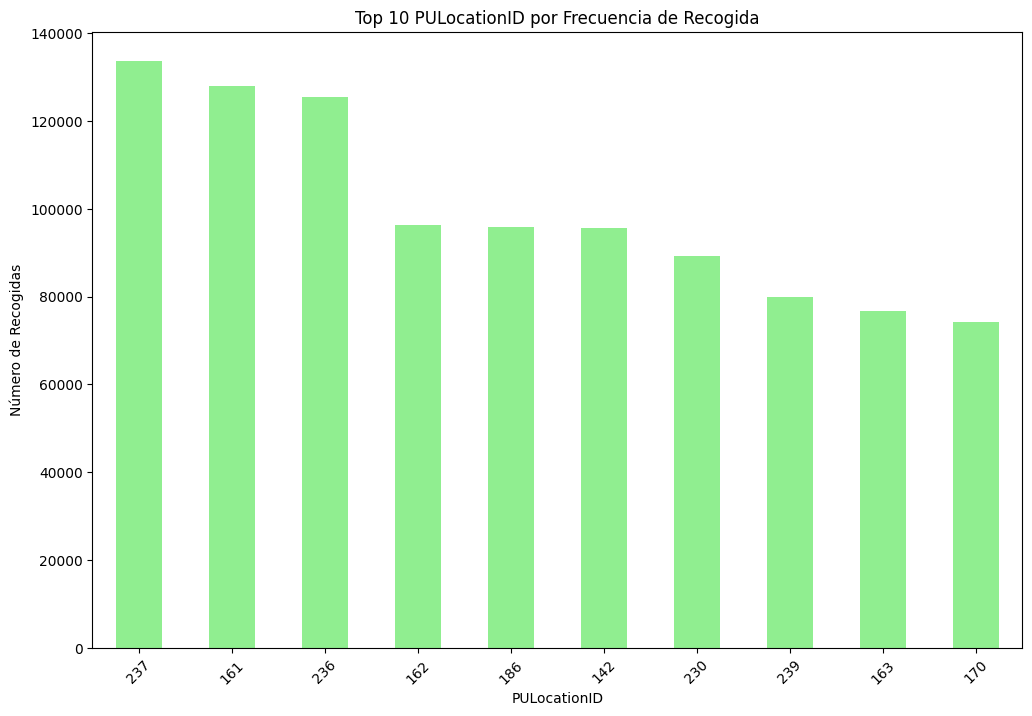

In [45]:
mathplot.figure(figsize=(10, 6))
pulocation_counts.head(5).plot(kind='bar', color='skyblue')
mathplot.title('Top 5 PULocationID por Frecuencia de Recogida')
mathplot.xlabel('PULocationID')
mathplot.ylabel('Número de Recogidas')
mathplot.xticks(rotation=45)
mathplot.show()

# Visualizar el Top 10
mathplot.figure(figsize=(12, 8))
pulocation_counts.head(10).plot(kind='bar', color='lightgreen')
mathplot.title('Top 10 PULocationID por Frecuencia de Recogida')
mathplot.xlabel('PULocationID')
mathplot.ylabel('Número de Recogidas')
mathplot.xticks(rotation=45)
mathplot.show()

In [47]:
# taxi_df_cleaned['tpep_pickup_datetime'] = pd.to_datetime(taxi_df_cleaned['pickup_datetime'])

# Extrae el día de la semana
taxi_df_cleaned['day_of_week'] = taxi_df_cleaned['tpep_pickup_datetime'].dt.day_name()

# Agrupa por PULocationID y día de la semana y cuenta las ocurrencias
daily_pulocation_counts = taxi_df_cleaned.groupby(['day_of_week', 'PULocationID']).size().reset_index(name='counts')

# Para ver el Top 5 PULocationID para cada día de la semana
top_daily_pulocation = (daily_pulocation_counts
                        .sort_values(['day_of_week', 'counts'], ascending=[True, False])
                        .groupby('day_of_week')
                        .head(5))

print("Top 5 PULocationID por Día de la Semana:")
print(top_daily_pulocation)

C:\Users\dario.maroto\AppData\Local\Temp\ipykernel_18624\1626631334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_df_cleaned['day_of_week'] = taxi_df_cleaned['tpep_pickup_datetime'].dt.day_name()


Top 5 PULocationID por Día de la Semana:
     day_of_week PULocationID  counts
116       Friday          237   19163
115       Friday          236   18320
53        Friday          161   16356
36        Friday          142   13993
75        Friday          186   12661
323       Monday          237   18284
253       Monday          161   17647
322       Monday          236   17296
275       Monday          186   14219
254       Monday          162   13636
447     Saturday          142   15651
524     Saturday          237   15396
595     Saturday           79   14384
523     Saturday          236   14270
535     Saturday          249   13804
731       Sunday          236   11083
732       Sunday          237   10832
646       Sunday          142   10777
725       Sunday          230   10719
804       Sunday           79   10706
871     Thursday          161   21381
937     Thursday          237   21364
936     Thursday          236   19406
872     Thursday          162   15797
891     T

In [49]:
taxi_df_cleaned['hour_of_day'] = taxi_df_cleaned['tpep_pickup_datetime'].dt.hour

# Agrupa por PULocationID y hora del día y cuenta las ocurrencias
hourly_pulocation_counts = taxi_df_cleaned.groupby(['hour_of_day', 'PULocationID']).size().reset_index(name='counts')

# Selecciona el Top 5 PULocationID para cada hora del día
top_hourly_pulocation = (hourly_pulocation_counts
                        .sort_values(['hour_of_day', 'counts'], ascending=[True, False])
                        .groupby('hour_of_day')
                        .head(5))

print("Top 5 PULocationID por Hora del Día:")
print(top_hourly_pulocation)

C:\Users\dario.maroto\AppData\Local\Temp\ipykernel_18624\1705811343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_df_cleaned['hour_of_day'] = taxi_df_cleaned['tpep_pickup_datetime'].dt.hour


Top 5 PULocationID por Hora del Día:
      hour_of_day PULocationID  counts
143             0           79    4792
100             0          249    4289
7               0          114    3552
123             0           48    2606
33              0          148    2377
...           ...          ...     ...
3783           23          249    4884
3709           23          142    4434
3767           23          230    4430
3822           23           79    4253
3806           23           48    3885

[120 rows x 3 columns]


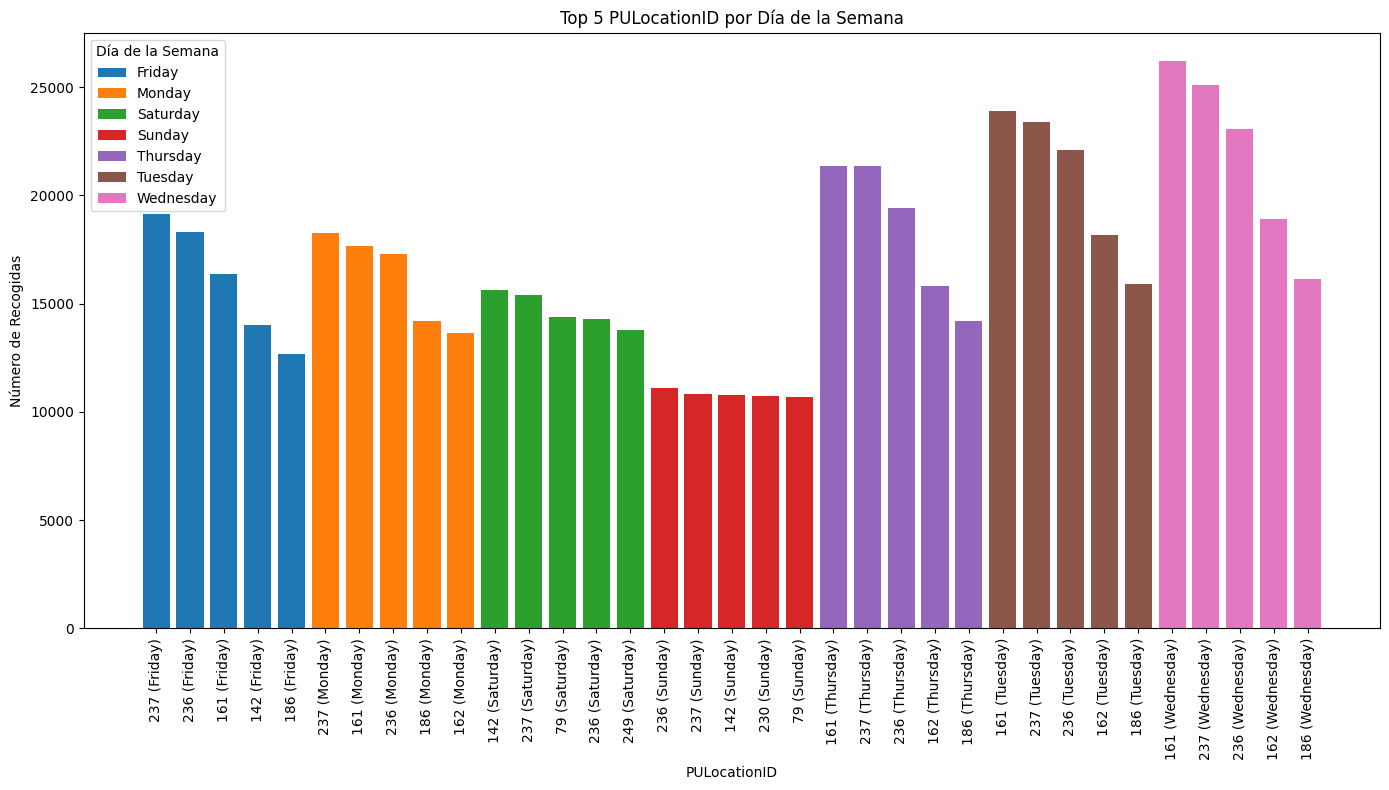

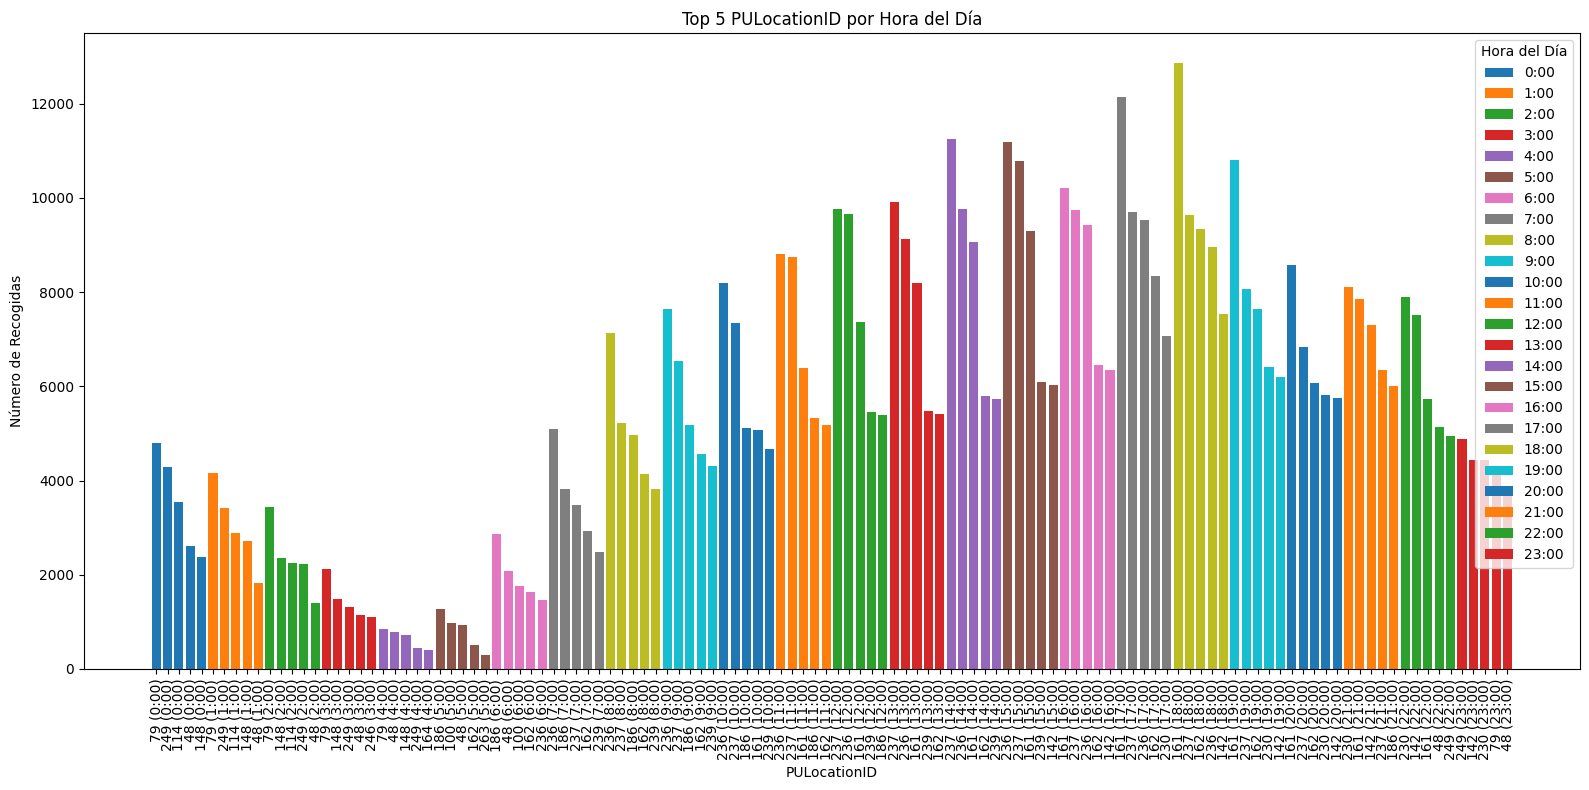

In [51]:
mathplot.figure(figsize=(14, 8))
for day in top_daily_pulocation['day_of_week'].unique():
    subset = top_daily_pulocation[top_daily_pulocation['day_of_week'] == day]
    mathplot.bar(subset['PULocationID'].astype(str) + ' (' + subset['day_of_week'] + ')', subset['counts'], label=day)

mathplot.title('Top 5 PULocationID por Día de la Semana')
mathplot.xlabel('PULocationID')
mathplot.ylabel('Número de Recogidas')
mathplot.xticks(rotation=90)
mathplot.legend(title='Día de la Semana')
mathplot.tight_layout()
mathplot.show()

# Visualiza el Top 5 PULocationID por cada hora del día
mathplot.figure(figsize=(16, 8))
for hour in top_hourly_pulocation['hour_of_day'].unique():
    subset = top_hourly_pulocation[top_hourly_pulocation['hour_of_day'] == hour]
    mathplot.bar(subset['PULocationID'].astype(str) + ' (' + subset['hour_of_day'].astype(str) + ':00)', subset['counts'], label=f'{hour}:00')

mathplot.title('Top 5 PULocationID por Hora del Día')
mathplot.xlabel('PULocationID')
mathplot.ylabel('Número de Recogidas')
mathplot.xticks(rotation=90)
mathplot.legend(title='Hora del Día')
mathplot.tight_layout()
mathplot.show()